## Summary

Created: 10/20/2017 (cloned from HAT-P-44 b analysis and plotting (updated simultaneous best model))

Last edit: 10/20

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*band.csv')
file_list.sort()
len(file_list)

3

## import lc

In [5]:
pd.read_csv(file_list[0]).head().columns

Index(['GJD', 'GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

In [6]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=',', parse_dates=True)
    #df.columns='GJD,GJD-2450000,flux,err,airmass,sky,dx,dy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    data[b]=df

In [7]:
data[b].head()

,GJD-2450000,flux,err,airmass,sky,dx,dy
GJD,,,,,,,
2.457613e+06,7613.009172,1.003733,0.001649,2.1933,786.8,-9.351,1.157
2.457613e+06,7613.009797,1.000975,0.001636,2.1801,795.5,-7.690,2.054
2.457613e+06,7613.011661,1.001777,0.001596,2.1404,705.7,-7.904,2.675
2.457613e+06,7613.014149,1.001378,0.001548,2.0902,664.5,-8.042,2.828
2.457613e+06,7613.017911,1.000332,0.001482,2.0183,625.1,-7.606,2.288


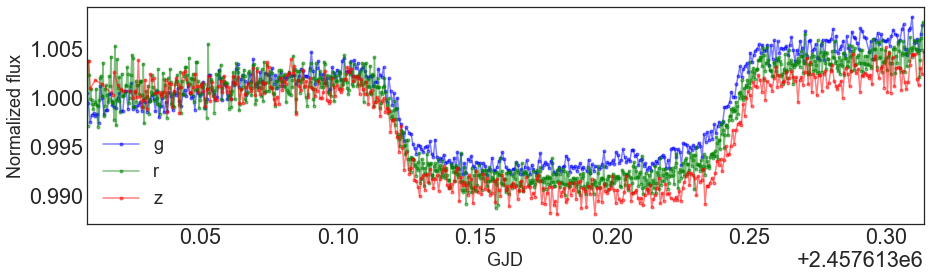

In [8]:
colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    df.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

In [9]:
fig.savefig('figs/raw.png')

## building the model

* See [exoplanet.org](http://exoplanets.org/detail/WASP-21_b) for published transit parameters

In [10]:
from uncertainties import ufloat 

P   = ufloat(4.322482,2.4e-5) #+1.9×10-5/-2.4×10-5
Rp  = ufloat(1.070,0.06)
Rs  = ufloat(1.060,0.04)
#tc  = ufloat(2454743.0419,0.0022) #+0.0019/-0.0022
t14 = ufloat(0.1398,0.004) #+0.0048/-0.004
b   = ufloat(0.23,0.1)     #0.23 +0.12/-0.15
a_s = ufloat(10.59,0.44)   #10.59 ± 0.44
k   = ufloat(np.sqrt(0.01082),np.sqrt(0.00037)) #0.01082 +0.00037/-0.00035
rhop= ufloat(0.319,0.067)
inc = ufloat(88.75,0.8)       # +0.84/-0.7)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [11]:
_P   = 4.322482
_tc  = 2454743.0419
_t14 = 0.1398
_b   = 0.23
_a_s = 10.59
_k   = np.sqrt(0.01082)
_inc = np.deg2rad(88.75)

def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

10.648013262755565

In [12]:
inc_ = np.arccos(_b/a_s_)
np.rad2deg(inc_)

88.762299226388166

In [13]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [14]:
tc_0 = 2.457613e6+0.19
q1_0, q2_0 = 0.4, 0.4

theta_true= [_k,tc_0,_a_s, _b, q1_0, q2_0]

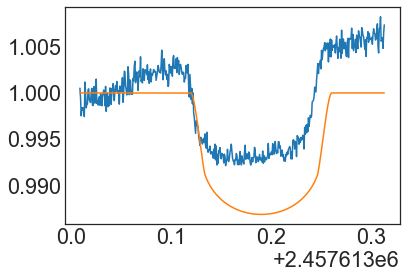

In [15]:
b='g'
f=data[b].flux
t=data[b].index

m=model_q(theta_true, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

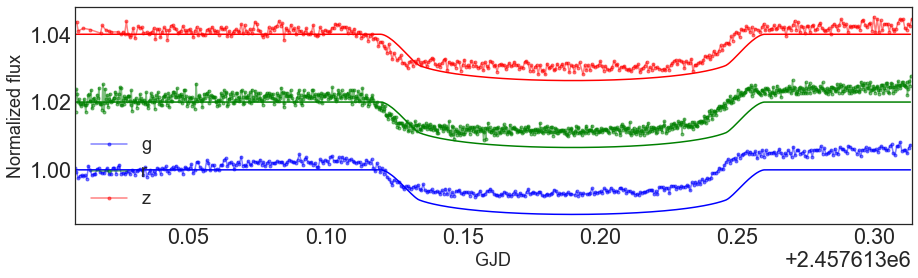

In [16]:
theta_vec = []

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for i,(b,c) in enumerate(zip(sorted(bands),colors)):
    df = data[b]
    df.flux.apply(lambda x: x+0.02*i).plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    #compute model
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    m=model_q(theta, t, _P)
    ax.plot(t,m+0.02*i,color=c)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
pl.legend()

In [17]:
import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

In [18]:
ts = [data[b].index for b in sorted(bands)]
fluxes = [data[b]['flux'] for b in bands]

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [19]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

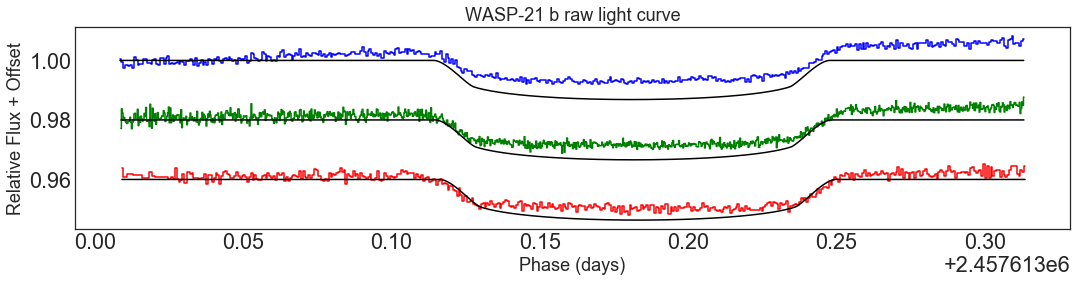

In [20]:
fontsize=18

ts,fluxes=[],[]
airmasses,uncs,dxs,dys=[],[],[],[]

colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,4), sharey=True)
for i,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)    
    f=d['flux']
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    res = op.minimize(obj, theta_vec[i], args=(t, f, _P), method='nelder-mead')
    model = model_q(res.x, t, _P)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    #sys mod params
    airmasses.append(d['airmass'])
    uncs.append(d['err'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(d['dx'].values)
    dys.append(d['dy'].values)
    
axs.set_title('WASP-21 b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [21]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -2300.45190456041
NLL after: -2410.8842095009004
residual: std=0.0041, rms=0.0041
--r--
NLL before: -5337.13792892415
NLL after: -5503.700930714802
residual: std=0.0019, rms=0.0033
--z--
NLL before: -2368.6221678586935
NLL after: -2466.620610109765
residual: std=0.0015, rms=0.0026


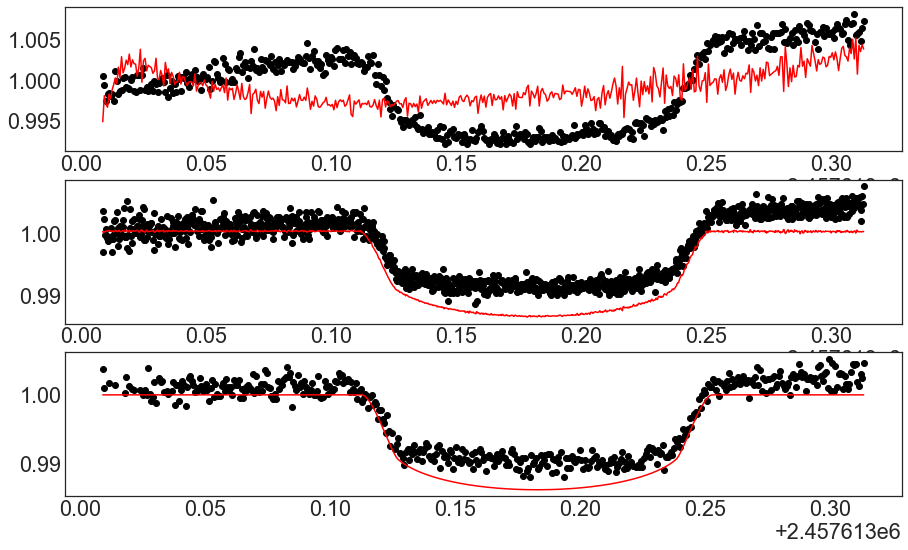

In [22]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)
    #remove outliers
    #d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d['flux']
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx = d['dx'].values
    dy = d['dy'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, _P, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, _P, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, _P, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

In [23]:
fig.savefig('figs/model-MLE.png')

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [24]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5800.0,100.0,4.2,0.1, -0.46, 0.11

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [25]:
theta

[0.10601922899156675, 2457613.19, 10.66817715302229, 0.23, 0.4, 0.4]

In [26]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [27]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.002]  
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = [a_s_]* 3

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [28]:
theta_sys = [k1,k2,k3,tc_0,a1,a2,a3,_b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,airmasses,dxs,dys]

In [29]:
#without ldp
logprob(theta_sys, *args)

10018.767453179526

In [30]:
#with ldp
logprob(theta_sys, *args, up=ldp)

9843.6630710788941

## Initial results: Parameter best estimates (including burn-in)

In [31]:
import gzip
#load gzip
loc='.'
#with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)
    
with gzip.GzipFile(os.path.join(loc,'lnp1.npy.gz'), "r") as g:
    lnp=np.load(g)

In [32]:
#after burn-in
import gzip
#with gzip.GzipFile(os.path.join(loc,'best_model_2.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'chain2.npy.gz'), "r") as g:
    chain2=np.load(g)
chain2.shape

(256, 10000, 32)

In [33]:
fc = chain2.reshape([-1,chain2.shape[-1]])
fc.shape

(2560000, 32)

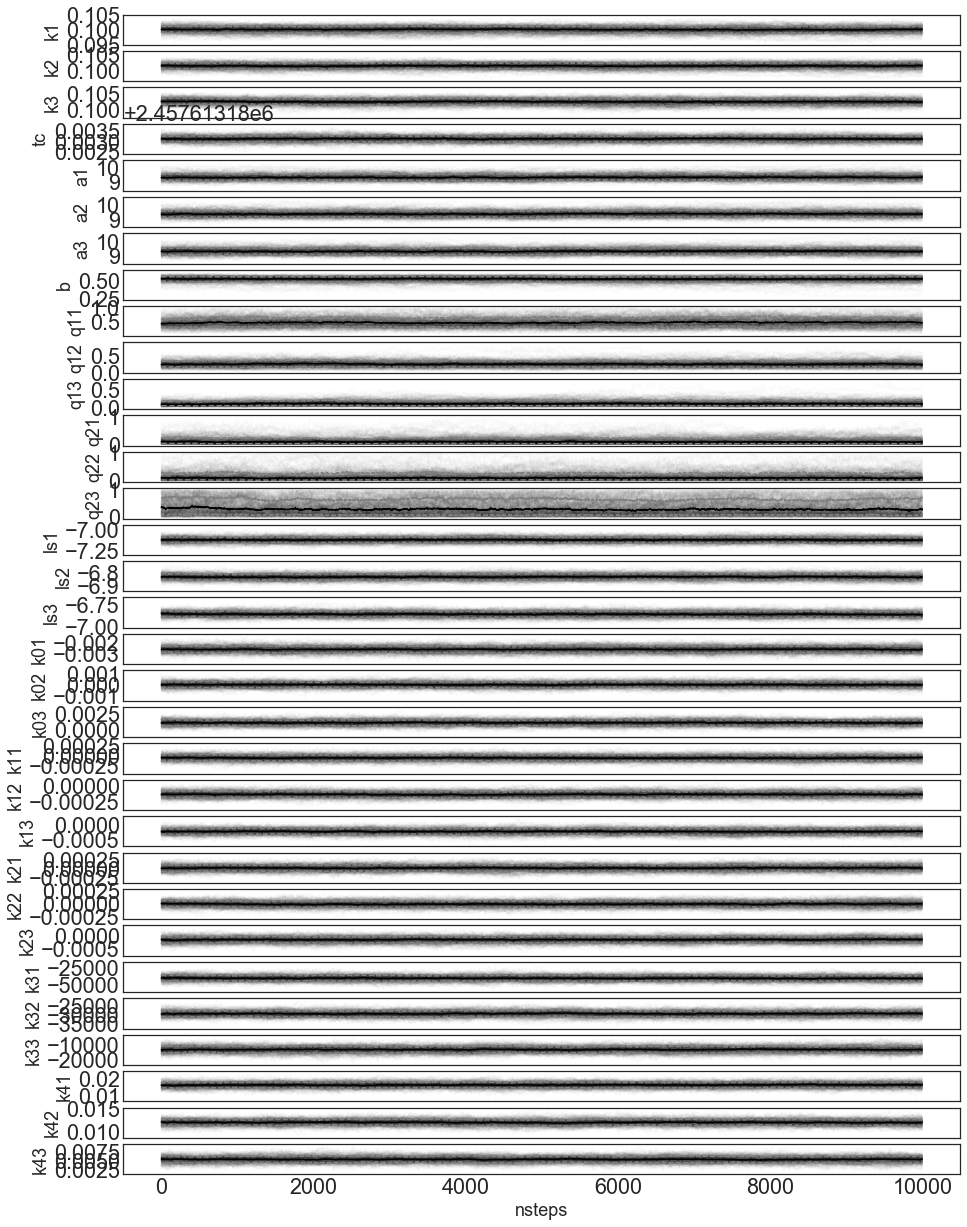

In [34]:
pl.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a1,a2,a3,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

nwalkers, nsteps, ndim = chain2.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [np.percentile(chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain2.T)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [35]:
fig.savefig('figs/chain2.png')

In [36]:
fc.shape

(2560000, 32)

In [37]:
burn=9000
fc = fc[256*burn:,:].reshape(-1,ndim)

In [38]:
#load
with gzip.GzipFile('lnp2.npy.gz', "r") as g:
    lnp2=np.load(g)
lnp2.shape

(2560000,)

In [39]:
lnp2=lnp2[nwalkers*burn:]

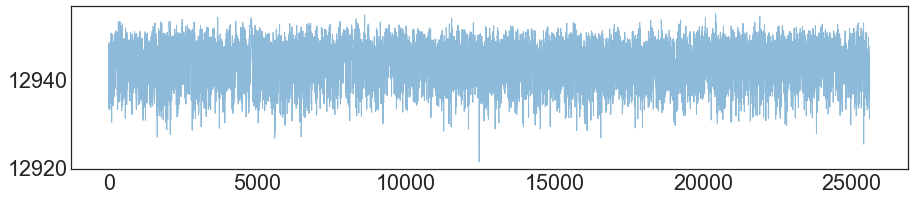

In [40]:
fig=pl.figure(figsize=(15,3))
pl.plot(lnp2[::10], lw=1, alpha=0.5)

Add 50,16,84-percentiles:

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [41]:
#using full chain excluding burn-in
max_idx=np.argmax(lnp2)

#posterior of parameter vector
pv=fc[max_idx,:]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k1: 0.1013
k2: 0.1016
k3: 0.1033
tc: 2457613.1831
a1: 9.1345
a2: 9.1746
a3: 9.1696
b: 0.5532
q11: 0.4340
q12: 0.2748
q13: 0.0598
q21: 0.0814
q22: 0.0158
q23: 0.6977
ls1: -7.1250
ls2: -6.8341
ls3: -6.8316
k01: -0.0028
k02: 0.0001
k03: 0.0010
k11: -0.0001
k12: -0.0002
k13: -0.0002
k21: 0.0000
k22: -0.0001
k23: -0.0001
k31: -40516.5324
k32: -29526.3304
k33: -12256.4345
k41: 0.0165
k42: 0.0120
k43: 0.0050


In [42]:
final_theta=np.copy(pv)

In [43]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

,k1,k2,k3,tc,a1,a2,a3,b,q11,q12,...,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43
count,256000.0000,256000.0000,256000.0000,2.5600e+05,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,...,2.5600e+05,2.5600e+05,2.5600e+05,2.5600e+05,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000
mean,0.1001,0.1016,0.1025,2.4576e+06,9.3150,9.3727,9.3223,0.5224,0.4987,0.2554,...,-2.2695e-04,2.9301e-05,-9.1399e-06,-1.5263e-04,-40570.8176,-29428.0861,-13059.0799,0.0165,0.0120,0.0053
std,0.0011,0.0009,0.0009,1.2481e-04,0.2077,0.2018,0.2214,0.0338,0.1496,0.0857,...,9.6072e-05,8.9566e-05,5.5525e-05,1.1079e-04,4029.0605,1521.2085,2157.9437,0.0016,0.0006,0.0009
min,0.0961,0.0981,0.0983,2.4576e+06,8.5426,8.6810,8.5593,0.3934,0.0940,0.0391,...,-6.6987e-04,-2.8566e-04,-2.1281e-04,-6.3614e-04,-55615.6392,-35579.4163,-22702.9069,0.0097,0.0096,0.0019
25%,0.0995,0.1010,0.1019,2.4576e+06,9.1696,9.2304,9.1640,0.4996,0.3916,0.1943,...,-2.9043e-04,-3.2258e-05,-4.4874e-05,-2.2668e-04,-43257.2380,-30436.2937,-14517.6681,0.0154,0.0116,0.0047
50%,0.1001,0.1016,0.1025,2.4576e+06,9.3113,9.3690,9.3197,0.5248,0.4930,0.2520,...,-2.3161e-04,2.9423e-05,-8.6738e-06,-1.5211e-04,-40582.2262,-29402.5212,-13075.6229,0.0165,0.0120,0.0053
75%,0.1008,0.1022,0.1031,2.4576e+06,9.4576,9.5103,9.4722,0.5471,0.5994,0.3139,...,-1.6250e-04,8.9335e-05,2.7287e-05,-7.8595e-05,-37883.3490,-28443.1696,-11566.5947,0.0176,0.0124,0.0059
max,0.1038,0.1051,0.1057,2.4576e+06,10.0919,10.0734,10.1469,0.6191,0.9996,0.6405,...,1.7107e-04,3.7348e-04,2.5786e-04,2.4954e-04,-23852.5735,-23473.4011,-4657.3822,0.0226,0.0145,0.0092


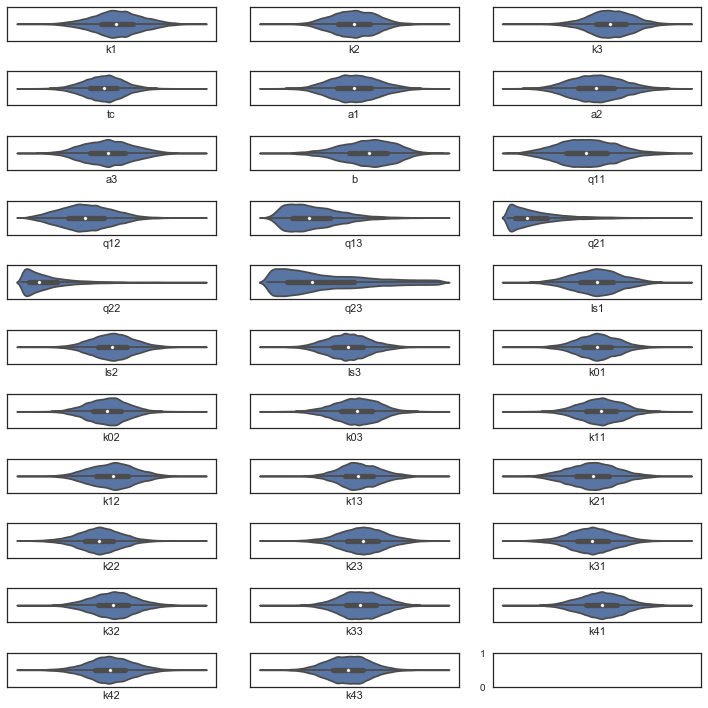

In [44]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(10,10))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

In [45]:
fig.savefig('figs/params_a_posteriori_distributions.png')

## BIC

In [46]:
def compute_bic(n,k,logL):
    '''
    n: number of data points
    m: number of parameters
    L: the maximized value of the likelihood function of the model
    '''
    return np.log(n)*m-2*logL

In [47]:
col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

cols=[col1,col2,col3]

m=chain2.shape[-1]

for n,(b,t,f,am,dx,dy,col) in enumerate(zip(bands,ts,fluxes,airmasses,dxs,dys,cols)):
    print(b)
    n=len(t)
    aux_vec = [am,dx,dy]
    logL=loglike([pv[i] for i in col], t, f, _P, aux_vec)
    print('loglike={}'.format(logL))
    bic=compute_bic(n,m,logL)
    print('BIC={}'.format(bic))

g
loglike=3202.0714909566814
BIC=-6206.382448996481
r
loglike=6791.985051947174
BIC=-13360.697100962163
z
loglike=2960.829917406757
BIC=-5725.114637834718


## Sample the flatchain

In [48]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [49]:
[param_names[i] for i in col1]

['k1', 'tc', 'a1', 'b', 'q11', 'q21', 'ls1', 'k01', 'k11', 'k21', 'k31', 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [50]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,am,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [airmass1,airmass2,airmass3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [am,xc,yc]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
        mod_sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, t, f, _P, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, _P, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, _P, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, t, f, _P, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

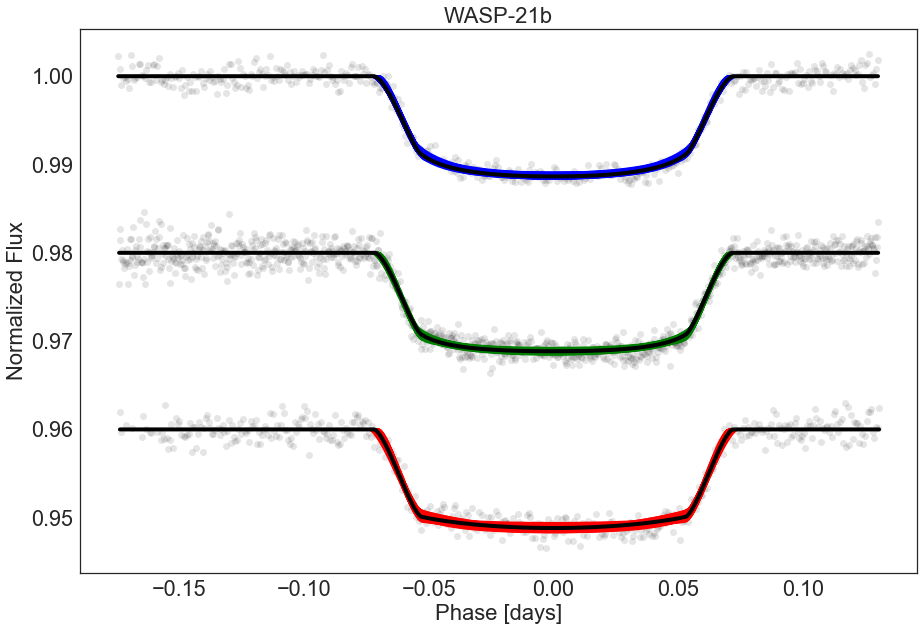

In [51]:
pl.style.use('seaborn-white')
colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('WASP-21b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

In [52]:
pl.savefig('figs/1000_posterior_samples.png')

### systematics model

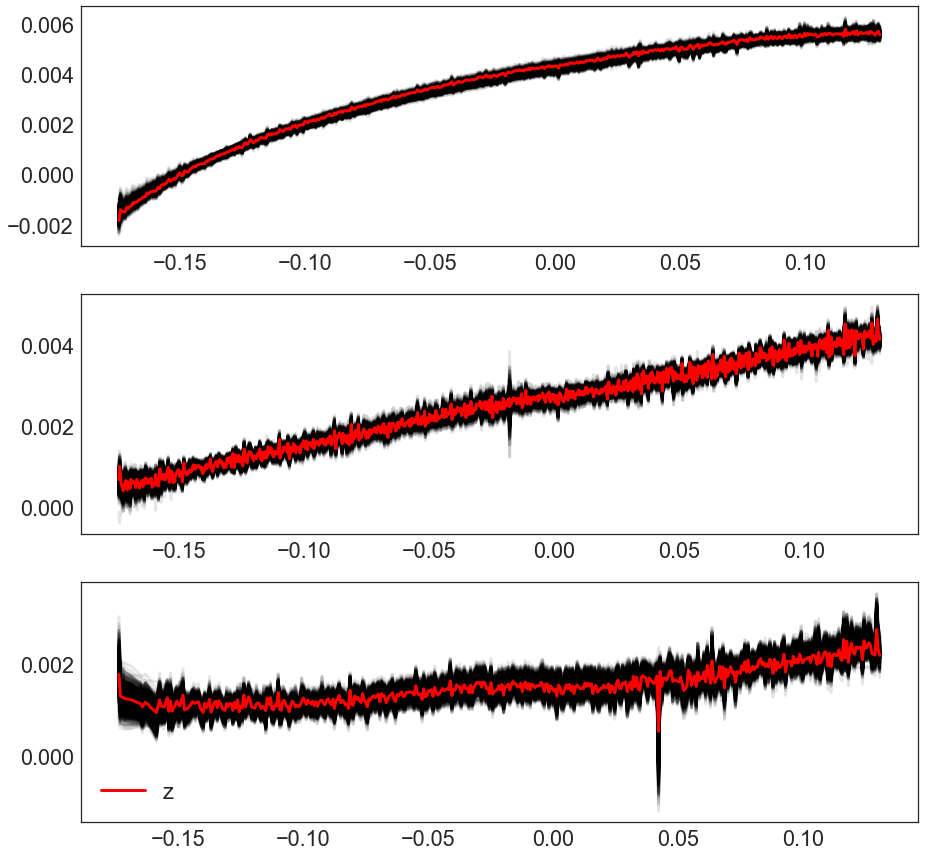

In [68]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-', label=b)
pl.legend(fontsize=fontsize)

In [54]:
pl.savefig('figs/sys.png')

### systematics + transit

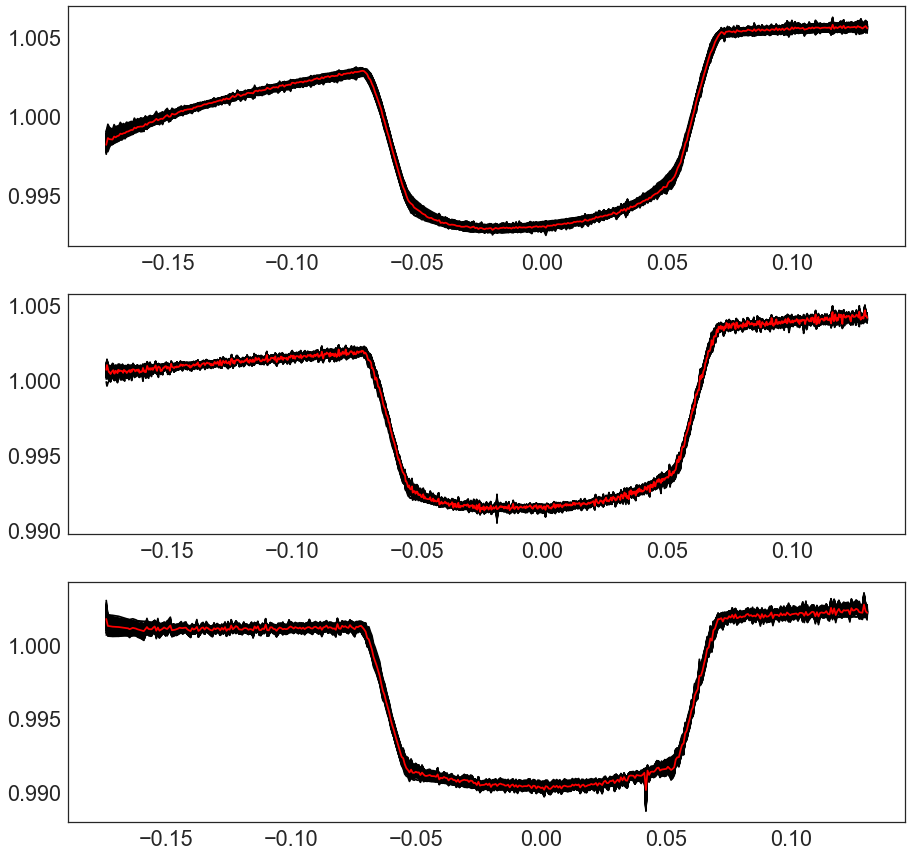

In [55]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in mod_sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-')

In [56]:
pl.savefig('figs/transit with sys.png')

## g-band

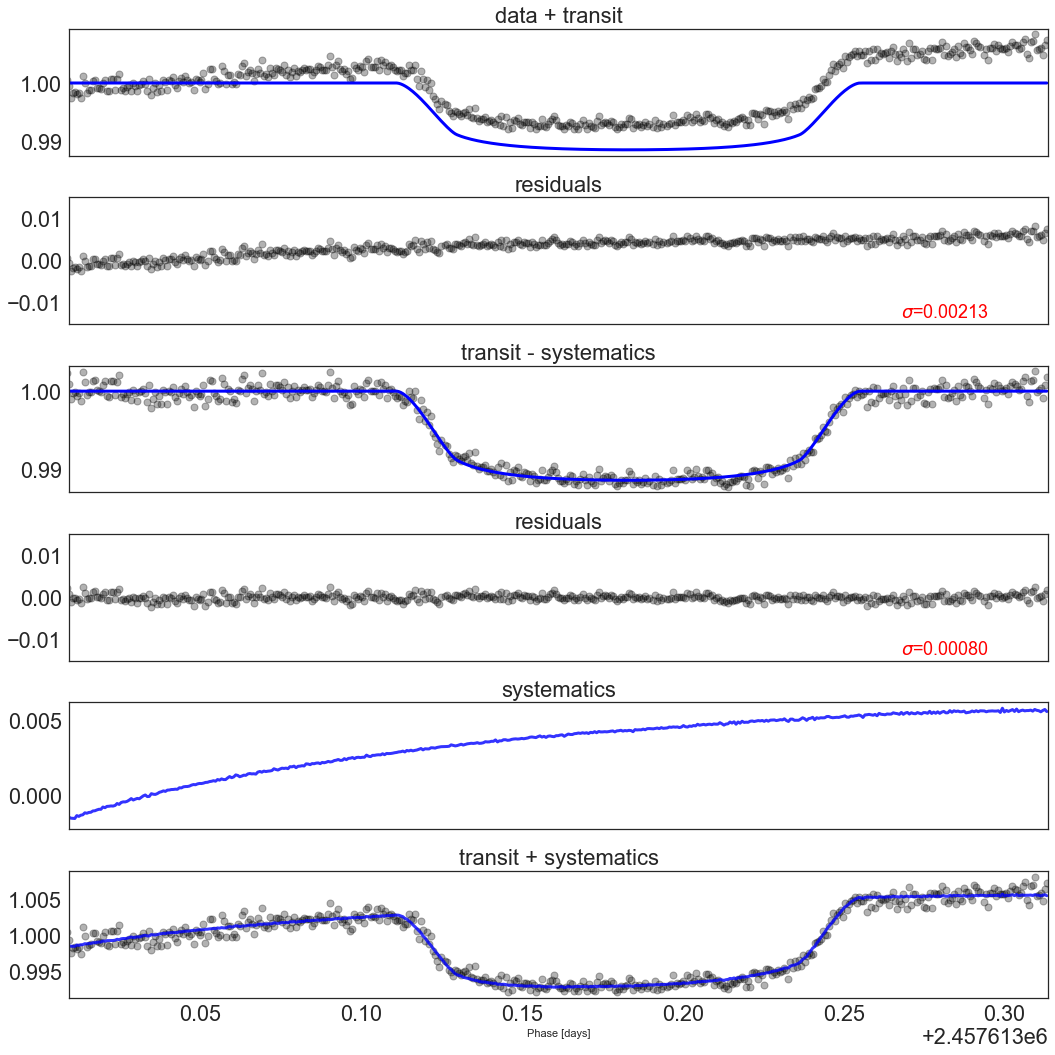

In [57]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
pl.rcParams['lines.linewidth'] = 3
n=0
b='g'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'b-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'b-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

## r-band

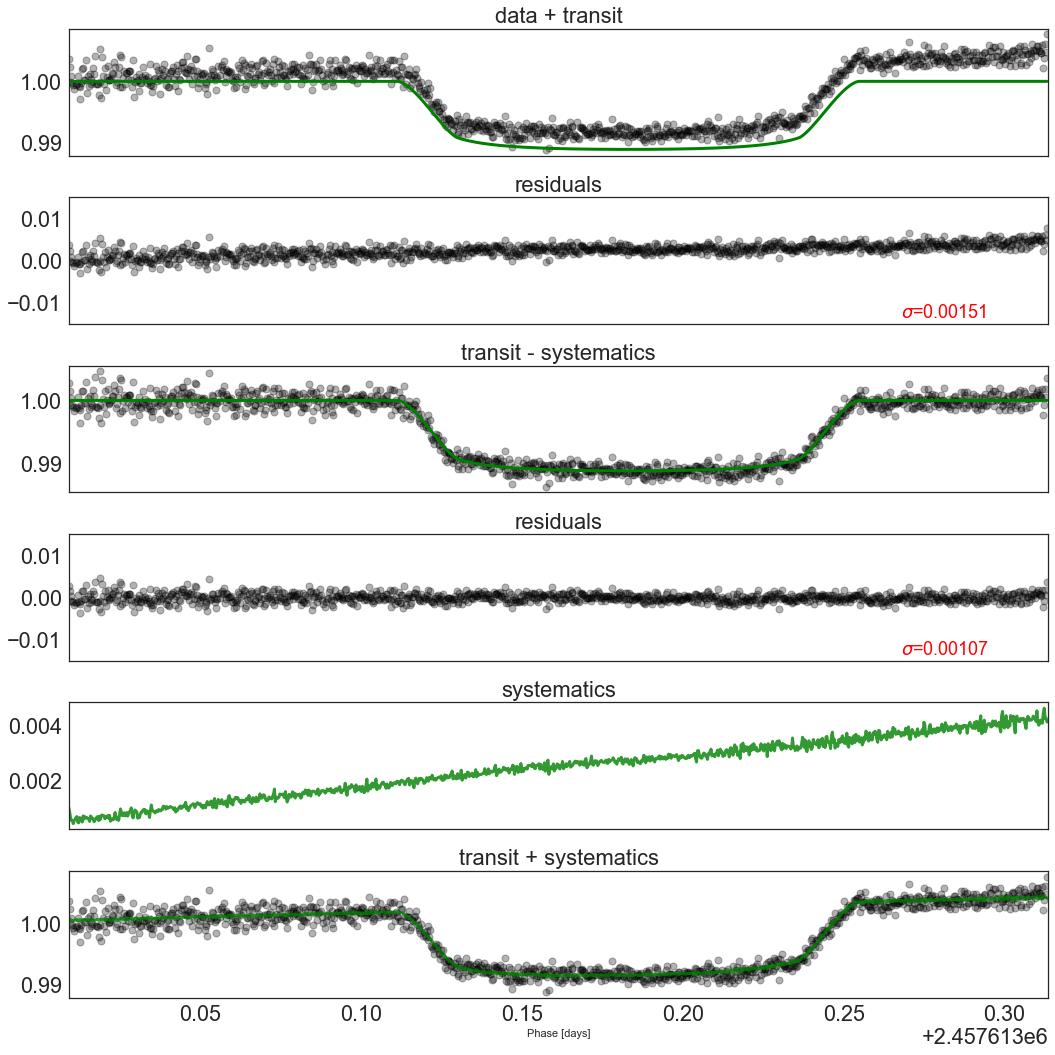

In [58]:
n=1
b='r'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'g-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'g-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'g-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'g-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

## z-band

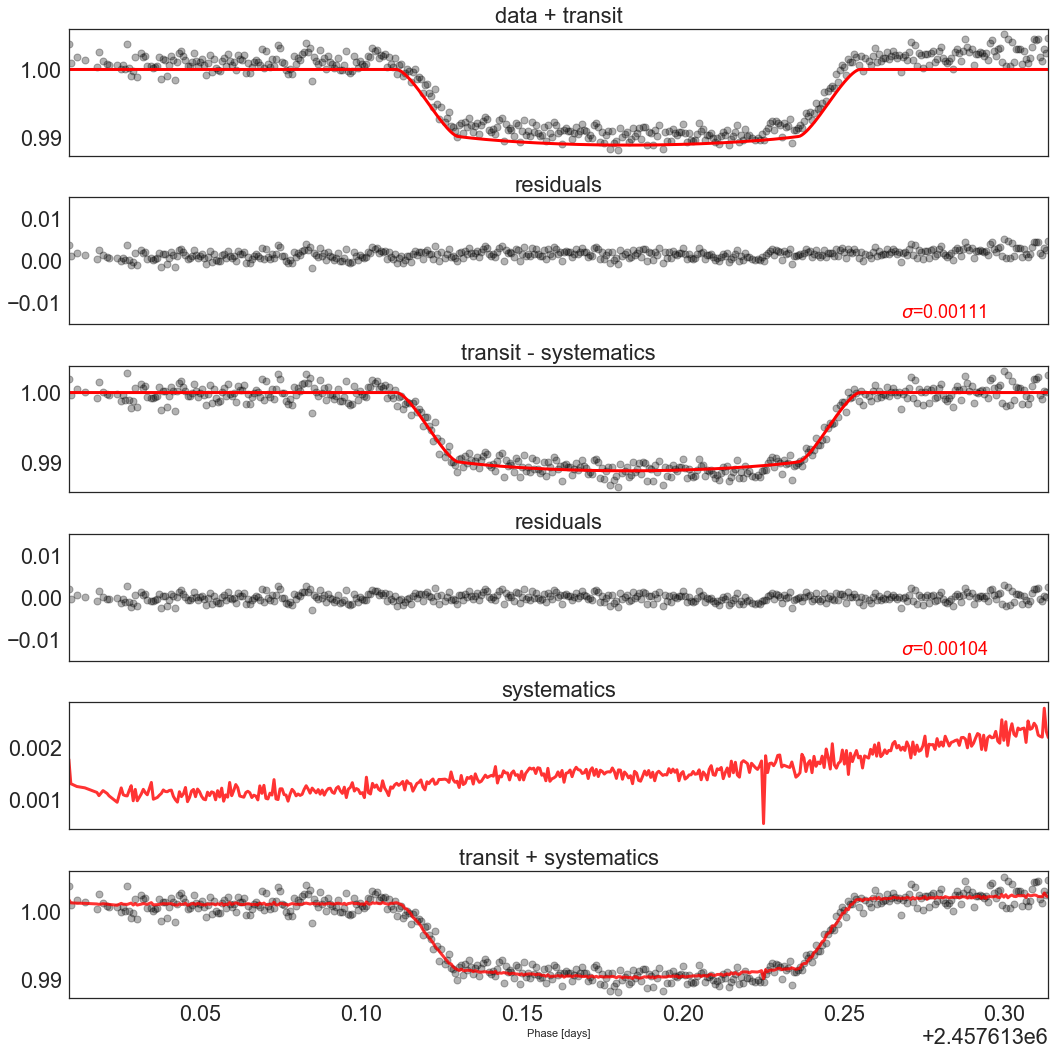

In [59]:
n=2
b='z'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'r-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'r-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

## rms of residuals

In [60]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [61]:
thinning=10
for n,b in enumerate(bands):
    print(b)
    print('rms={}'.format(rms(fluxes[n]-sys_best[b]-mod_best[b])*100))

g
rms=0.08010648717312051
r
rms=0.10745966626737624
z
rms=0.10398088949773586


## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning the residuals

Fukui-san's photometric precision achieved for HAT-P-14 (V=10):
```
g                       r                     z
RMS(10s)  = 0.10%       RMS(10s)  = 0.091%    RMS(30s) = 0.068%
RMS(5min) = 0.028%      RMS(5min) = 0.022%    RMS(5min) = 0.023%
```
$$
m_1-m_2=-2.5\log(f_1/f_2)\\
\rightarrow \frac{f_1}{f_2} = 10^{\Big(\frac{m_2-m_1}{2.5}\Big)}\\
\frac{f_1}{f_2} = 10^{\Big(\frac{13.2-10}{2.5}\Big)} = 19.9
$$
The photometric noise/ uncertainty goes with $\sqrt{\frac{f_1}{f_2}}$. Thus, the increase in the expected noise should be
$$
\sqrt{\frac{f_1}{f_2}}=4.47
$$
Currently, the rms of 0.23% for 5 minute binning, compared to Fukui-san's 0.028% is about an order of magnitude. I have to reduce this to about 5 to match the precisison achieved by Fukui-san.

In [62]:
rms(binned.values)

NameError: name 'binned' is not defined

## binning before model fitting

In [ ]:
from pandas.plotting import autocorrelation_plot

fig = pl.figure(figsize=(15,4))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)

In [ ]:
fig.savefig('figs/autocorr')

correlation: u1, u2; k1, k3; i, a

In [ ]:
n,b=0,'g'

d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])


n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

## Save

In [ ]:
final_df.to_csv('after_mcmc_wasp21b.csv')

In [ ]:
np.save('theta_post.csv',final_theta)

In [ ]:
import corner


fig = corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig.savefig('figs/joint_k.png')

In [ ]:
import corner

fig = corner.corner(fc[:,3:8], labels=param_names[3:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig.savefig('figs/joint_tc_a_inc.png')

In [ ]:
fig = corner.corner(fc[:,8:14], labels=param_names[8:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig.savefig('figs/limbdark_q1q2.png')

In [ ]:
fig = corner.corner(fc[:,14:17], labels=param_names[14:17], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig.savefig('figs/logsigma.png')

In [ ]:
fig = corner.corner(fc[:,17:], labels=param_names[17:], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig.savefig('figs/joint_coeffs.png')

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [ ]:
post=[]
print('sigma:')
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_lower, mean, sig_upper=np.percentile(fc_sample[:,i],[16,50,84],axis=0)
    vals='{0}={1:.4f}\t+ {2:.4f} \t- {3:.4f}'.format(p,j,mean, sig_upper, sig_lower)
    post.append(vals)
    print(vals)

In [ ]:
np.save('theta_with_unc_wasp21b.csv',post)

In [ ]:
pv[3]

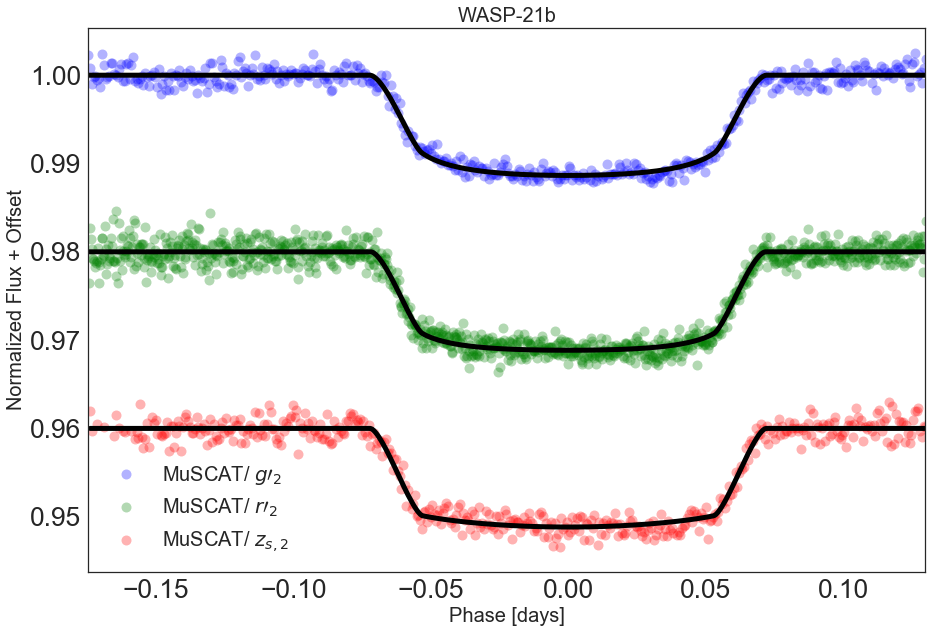

In [69]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_wasp21b.csv', parse_dates=True, index_col=0)

tc=pv[3]
final_df.index=final_df.index-tc

fig,ax=pl.subplots(1,1,figsize=(15,10))

cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.02
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('WASP-21b', fontsize=fontsize)
ax.legend(labels,loc='lower left', fontsize=fontsize)

In [70]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

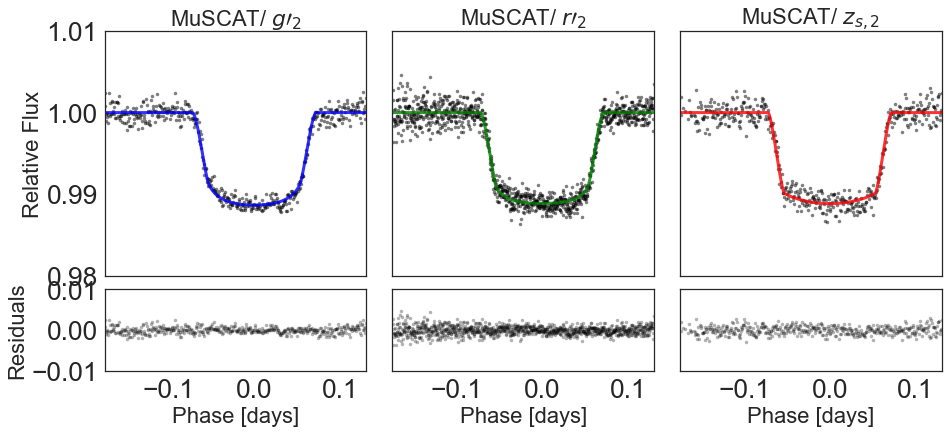

In [75]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_wasp21b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.98,1.01]
ylims2= [-0.01,0.01]

tc=pv[3]
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [76]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

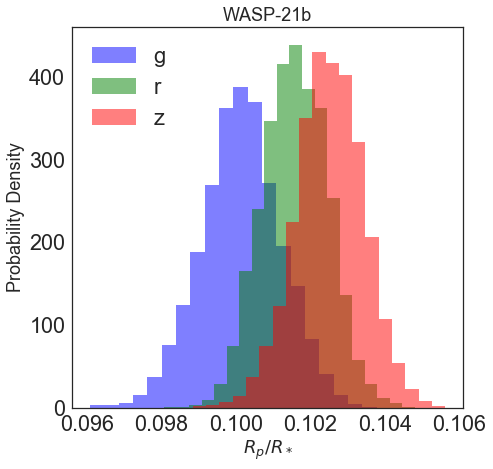

In [65]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('WASP-21b',fontsize=18)
pl.legend(fontsize=fontsize)

In [66]:
fig.savefig('figs/radius ratios.png')

In units of Jupiter radius

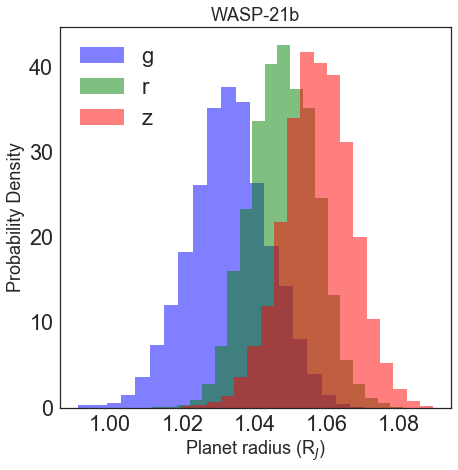

In [87]:
from astropy import units as u

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

#Rs = Rs.nominal_value

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    factor=Rs*u.solRad.to(u.jupiterRad)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('WASP-21b',fontsize=18)
pl.legend(fontsize=fontsize)

In [89]:
fig.savefig('figs/radius ratios Rjup.png')

In [78]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.14324240871647642
diff=-0.004334639202497256
sigma=-0.030260865070182708


In [79]:
(sigma_g_plus-sigma_z_minus)/np.mean([np.std(k_samples[0]),np.std(k_samples[2])])

-0.44795829020598188

In [80]:
from scipy.stats import mode

for i in range(3):
    print(np.mean(k_samples[i]),np.median(k_samples[i]), np.std(k_samples[i]))

0.100144617794 0.100138634442 0.00106337977391
0.101595115758 0.101596567579 0.000868844967167
0.102525219224 0.102524734301 0.000904237086909


In [81]:
mean1=np.mean(k_samples[0])
var1=np.std(k_samples[0])**2
mean2=np.mean(k_samples[2])
var2=np.std(k_samples[2])**2

n=len(k_samples[0])
z=(mean1-mean2)/np.sqrt((var1/n+var2/n))
z

-272.87593939367724

In [89]:
fig.savefig('figs/radius ratios Rjup.png')

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [95]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.10013863  0.09910008  0.10120951]
[ 0.10159657  0.1007083   0.10247264]
[ 0.10252473  0.10165554  0.10342758]


In [96]:
pv[:3]

array([ 0.10079955,  0.10175011,  0.10188271])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=0.000009


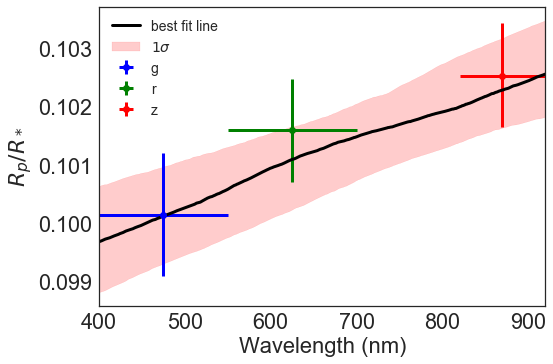

In [63]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
n = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
for i in range(n):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')
ax.plot(xi,mid,'k-',label='best fit line')

# plot each sample
# for slop,interc in zip(slopes,intercepts):
#     ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)

#
bands='g,r,z'.split(',')
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [64]:
fig.savefig('figs/spectrum.png')

slope=0.000006


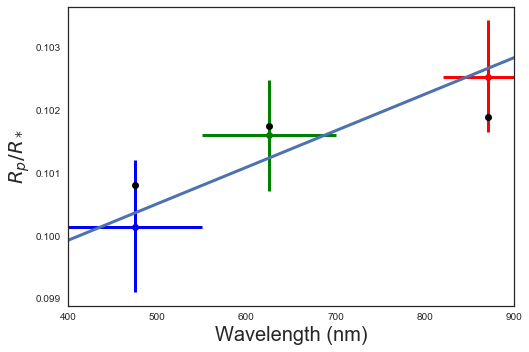

In [107]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820] #lower bandwidth
xs2=[550,700,920] #upper bandwidth
xmean=np.mean([xs1,xs2],axis=0)

Rs=0.11130057502097643

ys=[]
new_axis=[]

colors='b,g,r'.split(',')
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    new_axis.append(y*Rs)
    
#add i-band measurement
#ax.errorbar(763,0.1344,yerr=0.0011,fmt='o',color='orange')

#Na absorption line
#ax.axvline(x=590, ymin=0,ymax=1, linestyle='--', color='k')
#K absorption line
#ax.axvline(x=770, ymin=0,ymax=1, linestyle='--', color='k')


# ax2 = ax.twinx() # now, ax2 is responsible for "top" axis and "right" axis
# ax2.set_xticks(new_axis)
# ax2.set_xlabel('R_p (R_${Jup}$)')

ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)
ax.set_xlim(400,900)
print('slope={:.6f}'.format(slope))

In [ ]:
pl.savefig('figs/spectrum.png')

In [109]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

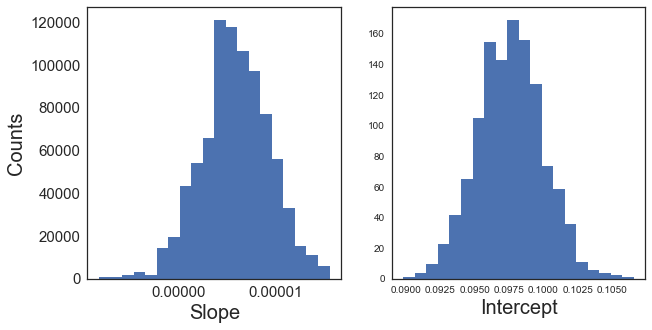

In [110]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

## significance of detection

In [111]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

-1.66571323492


slope=0.000006


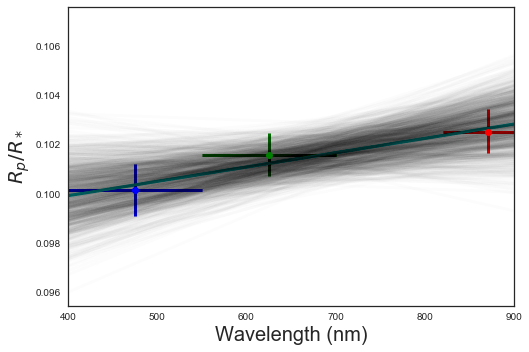

In [112]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=0.11130057502097643
ys=[]

fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))

In [133]:
(pv[0]-pv[1])*Rs

-2.1823214009327398e-05

slope=0.000005


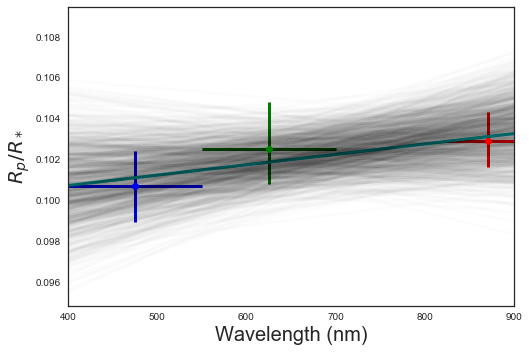

In [134]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))